In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25, 10
%matplotlib inline

In [2]:
full_meteo = pd.read_csv("./formatted_data/full_meteo.csv")
full_meteo.index = pd.to_datetime(full_meteo["DATE"])
full_meteo.head()

,DATE,MAX_TEMP,DAY,YEAR
DATE,,,,
1975-01-01,1975-01-01,8.1,01-01,1975
1975-01-02,1975-01-02,3.2,01-02,1975
1975-01-03,1975-01-03,4.5,01-03,1975
1975-01-04,1975-01-04,6.4,01-04,1975
1975-01-05,1975-01-05,7.0,01-05,1975


In [3]:
from statsmodels.tsa.stattools import adfuller
import pdb
def test_stationarity(timeseries):    
    # Determing rolling statistics  
    rolmean = timeseries.rolling(window=365).mean()
    # Plot rolling statistics:  
    fig = plt.figure(1, figsize=(20, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')  
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')  
    plt.legend(loc='best')  
    plt.title('Rolling Mean')  
    plt.show(block=False)    
    # Perform Augmented Dickey-Fuller test:  
    print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])  
    for key,value in dftest[4].items():    
        dfoutput['Critical Value (%s)'%key] = value  
    print(dfoutput)

/Users/vincentvillet/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


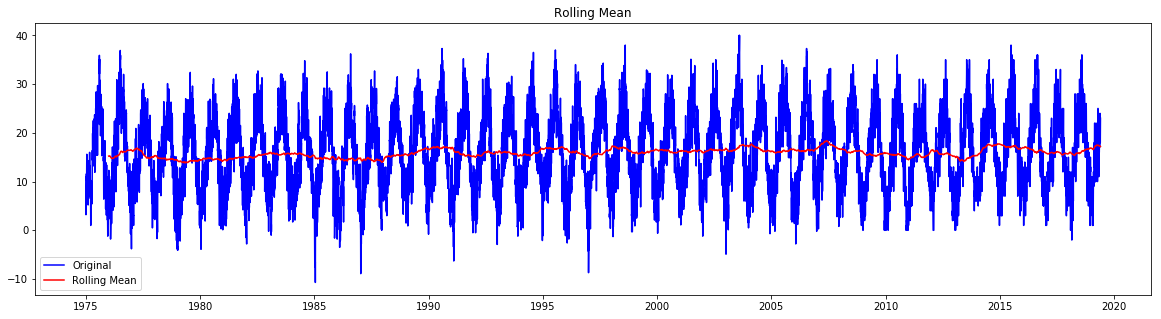

Results of Augmented Dickey-Fuller test:
Test Statistic                -8.861958e+00
p-value                        1.474659e-14
#Lags Used                     4.300000e+01
Number of Observations Used    1.617800e+04
Critical Value (1%)           -3.430754e+00
Critical Value (5%)           -2.861719e+00
Critical Value (10%)          -2.566865e+00
dtype: float64


In [4]:
test_stationarity(full_meteo["MAX_TEMP"])

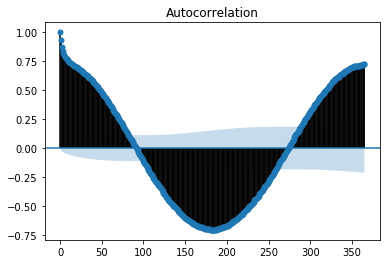

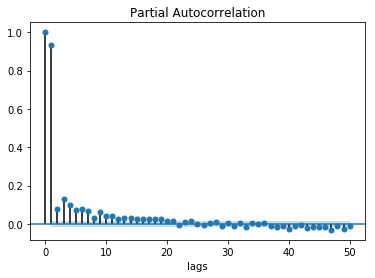

In [5]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
plot_acf(full_meteo["MAX_TEMP"], lags=365)
plot_pacf(full_meteo["MAX_TEMP"], lags=50)
plt.xlabel('lags')
plt.show()

In [6]:
test = [full_meteo.index[i] - full_meteo.index[i-1] for i in range(1, len(full_meteo))]

In [7]:
from datetime import datetime, timedelta
for i in range(1, len(full_meteo)):
    if full_meteo.index[i] - full_meteo.index[i-1] > timedelta(days=1):
        print(full_meteo.index[i-1], full_meteo.index[i])

In [8]:
from statsmodels.tsa.arima_model import ARMA

import itertools
p = q = range(0, 3)
pq = itertools.product(p, q)
for param in pq:  
    try:    
        mod = ARMA(full_meteo["MAX_TEMP"], order=param, freq="D")    
        results = mod.fit()    
        print('ARMA{} - AIC:{}'.format(param, results.aic))  
    except Exception as e:
        print(e)
        continue

/Users/vincentvillet/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


ARMA(0, 0) - AIC:112321.35500420946
ARMA(0, 1) - AIC:97721.97957565964
ARMA(0, 2) - AIC:90628.05827399425
ARMA(1, 0) - AIC:79642.45276006917
ARMA(1, 1) - AIC:79506.70269792681
ARMA(1, 2) - AIC:79068.83313425038
ARMA(2, 0) - AIC:79547.55095507743
ARMA(2, 1) - AIC:78702.2450461486
ARMA(2, 2) - AIC:78656.53009465063


/Users/vincentvillet/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


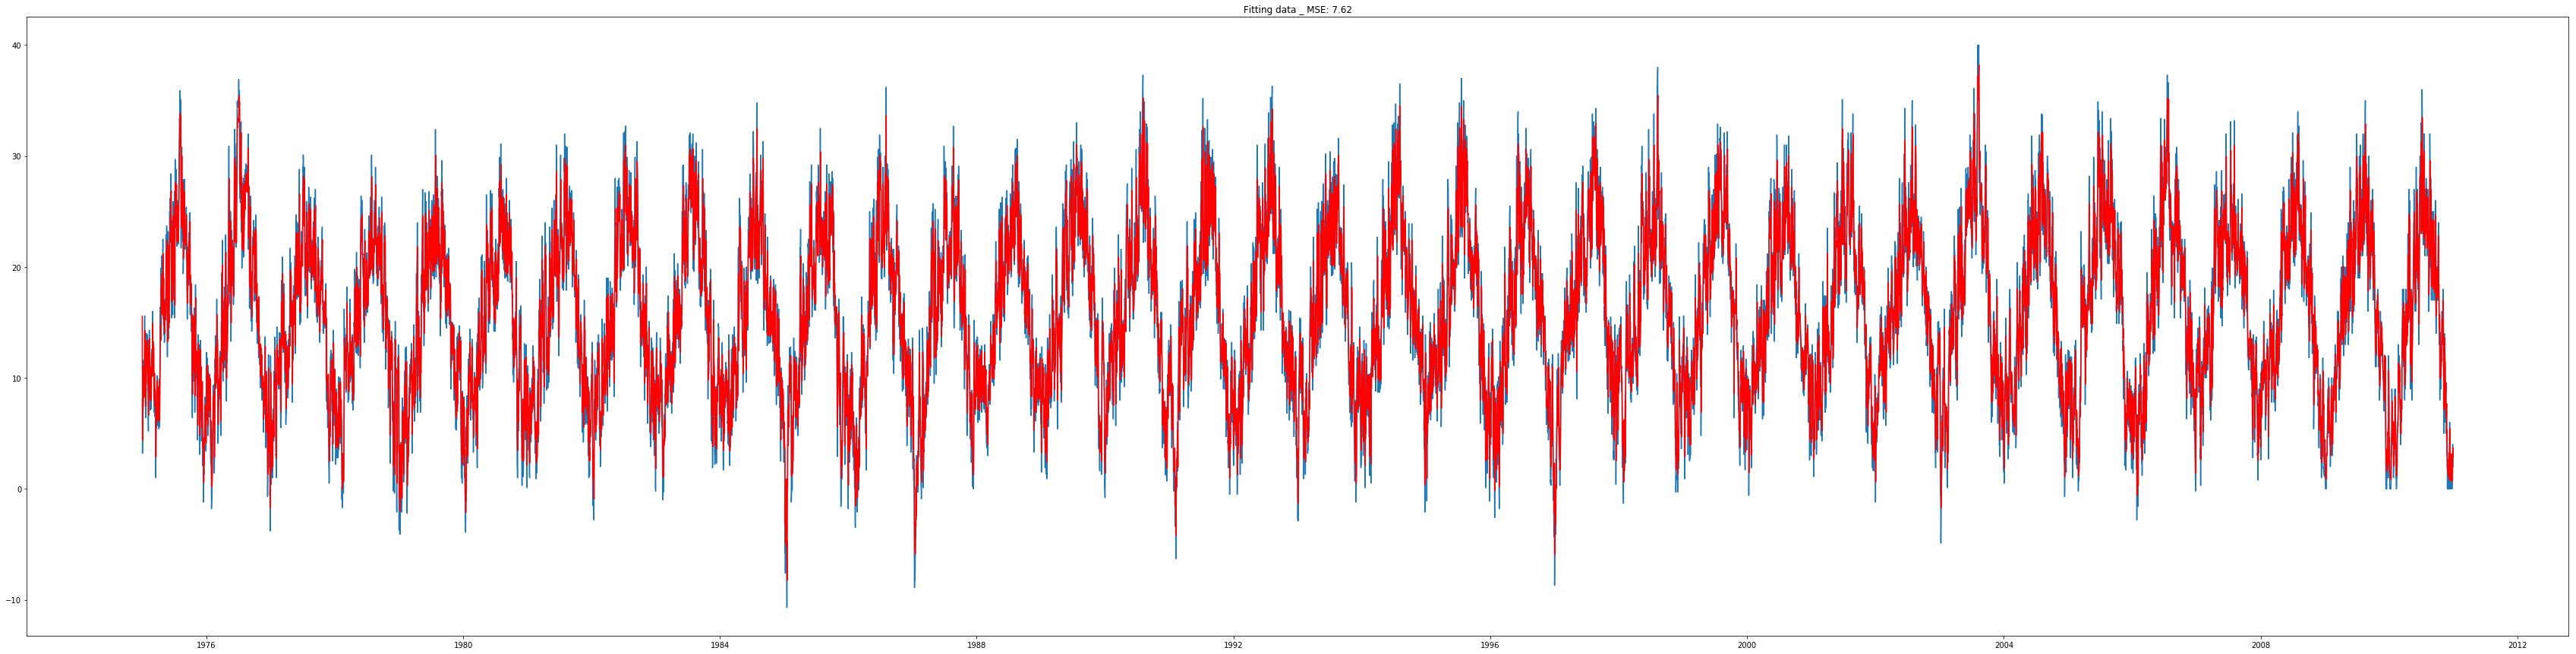

In [42]:
model = ARMA(full_meteo[full_meteo["YEAR"] <= 2010]["MAX_TEMP"], order=(2,3))
results_MA = model.fit()
fig = plt.figure(1, figsize=(60, 15))
plt.plot(full_meteo[full_meteo["YEAR"] <= 2010]["MAX_TEMP"])
plt.plot(results_MA.fittedvalues, color='red')
plt.title('Fitting data _ MSE: %.2f'% (((results_MA.fittedvalues-full_meteo["MAX_TEMP"])**2).mean()))
plt.show()

In [43]:
predictions, std_err, conf_int = results_MA.forecast(steps=len(full_meteo[full_meteo["YEAR"] > 2010]))

In [44]:
predictions

array([ 2.23527213,  2.47966189,  2.65986066, ..., 15.58037299,
       15.58037299, 15.58037299])

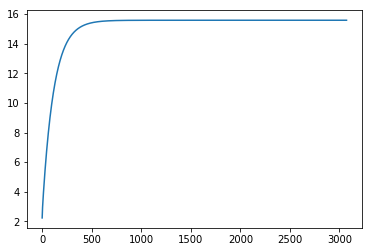

In [46]:
plt.plot(predictions)
plt.show()

/Users/vincentvillet/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


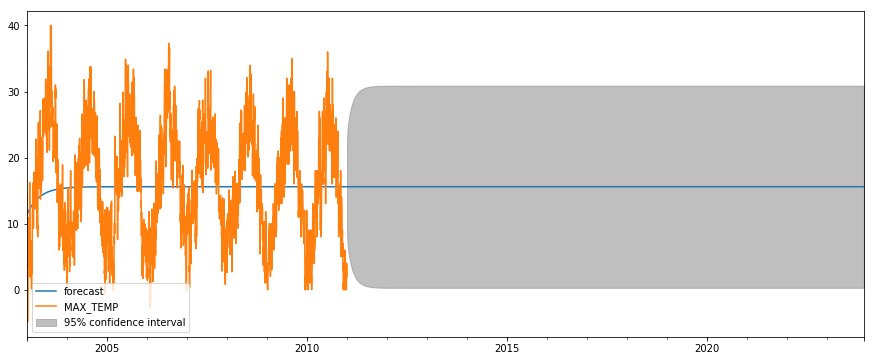

In [47]:
fig, ax = plt.subplots(figsize=(15, 6))
fig = results_MA.plot_predict('01/01/2003', '12/01/2023', ax=ax, dynamic=True)
ax.legend(loc='lower left')
plt.show()

/Users/vincentvillet/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/vincentvillet/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


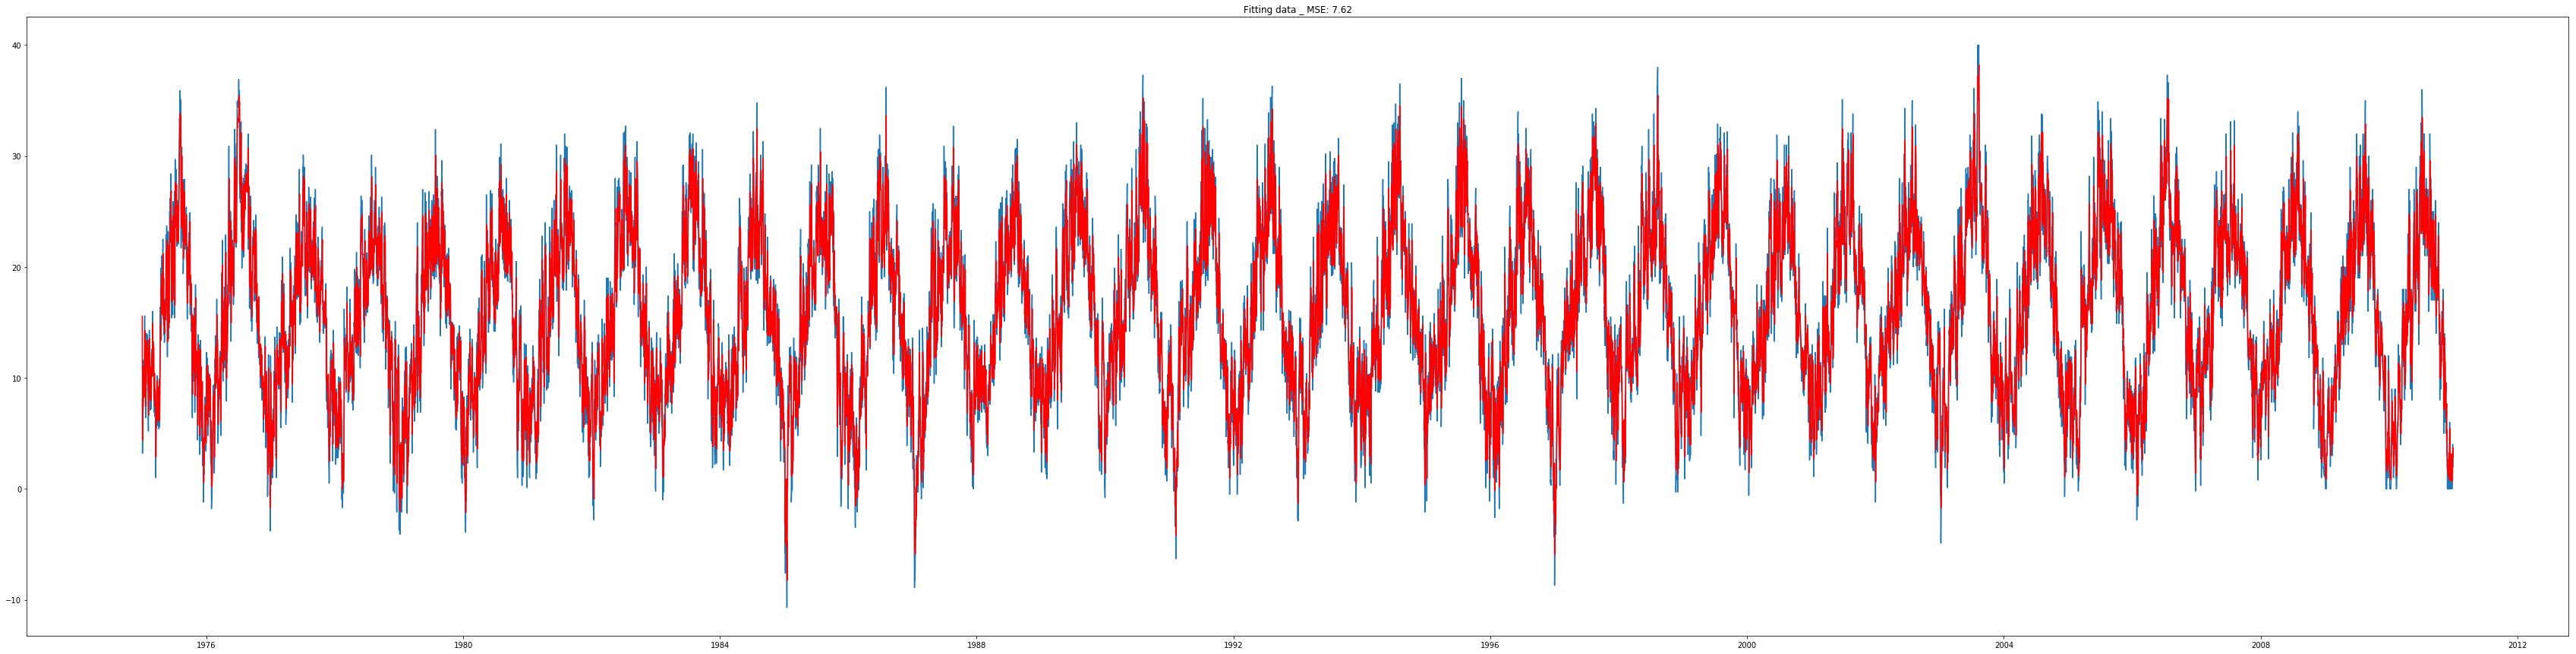

In [62]:
# Test ARIMA model
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(full_meteo[full_meteo["YEAR"] <= 2010]["MAX_TEMP"], order=(2,0,3))
results_MA = model.fit(disp=True)
fig = plt.figure(1, figsize=(60, 15))
plt.plot(full_meteo[full_meteo["YEAR"] <= 2010]["MAX_TEMP"])
plt.plot(results_MA.fittedvalues, color='red')
plt.title('Fitting data _ MSE: %.2f'% (((results_MA.fittedvalues-full_meteo["MAX_TEMP"])**2).mean()))
plt.show()

/Users/vincentvillet/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


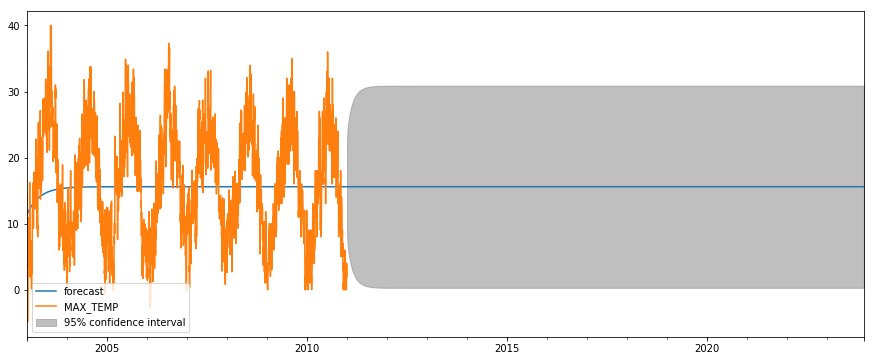

In [61]:
fig, ax = plt.subplots(figsize=(15, 6))
fig = results_MA.plot_predict('01/01/2003', '12/01/2023', ax=ax, dynamic=True)
ax.legend(loc='lower left')
plt.show()